In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas
import numpy

# Input data

In [2]:
data = pandas.read_csv('hits_1000.csv', index_col=False)
data = data[data.event.values < 100]

data.head()

,event,particle,layer,iphi,x,y
0,0,0,5,39276,55.103343,-401.233874
1,0,6,5,22685,-381.682239,135.438799
2,0,3,3,6082,160.995866,139.460859
3,0,5,2,27787,-35.433651,-150.895515
4,0,5,1,15230,-19.627350,-82.702885


# Hough Transform Modification

In [3]:
from hough import Hough
from regression import TrackRegression

class ModifiedHough(Hough):
    
    def new_track_inds(self, track_inds, n_hits):

        used = numpy.zeros(n_hits)
        new_track_inds = []


        while 1:

            track_lens = numpy.array([len(i[used[i] == 0]) for i in track_inds])
            
            if len(track_lens) == 0:
                break
                
            max_len = track_lens.max()

            if max_len < self.min_hits:
                break

            one_track_inds = track_inds[track_lens == track_lens.max()][0]
            one_track_inds = one_track_inds[used[one_track_inds] == 0]

            used[one_track_inds] = 1
            new_track_inds.append(numpy.array(one_track_inds))

        return numpy.array(new_track_inds)
    
    def new_track_params(self, track_inds, x, y):
        
        new_track_params = []
        
        for track in track_inds:
            
            tr = TrackRegression()
            tr.fit(x[track], y[track])
            
            new_track_params.append([tr.theta_, tr.invr_])
            
        return numpy.array(new_track_params)

    
    def predict(self, x, y): # This method must be!
        
        Hough.predict(self, x, y)
        
        self.track_inds_ = self.new_track_inds(self.track_inds_, len(x)) # This attribute must be!
        self.track_params_ = self.new_track_params(self.track_inds_, x, y) # This attribute is optional

## One event

In [4]:
toy_event_id = 0
event = data[data.event.values == toy_event_id]

In [5]:
from hough import Hough

h = ModifiedHough(n_theta_bins=5000, n_radius_bins=1000, min_radius=20., min_hits=6)
h.predict(event.x.values, event.y.values)

matrix_hough = h.matrix_hough_
track_inds = h.track_inds_
track_params = h.track_params_

In [6]:
print "List of tracks. A track is a list of hit indexes. One hit can belong to several recognized tracks."
track_inds

List of tracks. A track is a list of hit indexes. One hit can belong to several recognized tracks.


array([array([ 3, 23, 29, 30, 32, 43, 53, 54]),
       array([13, 19, 22, 28, 35, 48, 52]),
       array([ 0,  9, 14, 26, 34, 38, 42]),
       array([ 1, 11, 12, 20, 21, 27, 55]),
       array([ 7,  8, 10, 37, 46, 47, 57]), array([ 2,  5, 16, 36, 49, 56])], dtype=object)

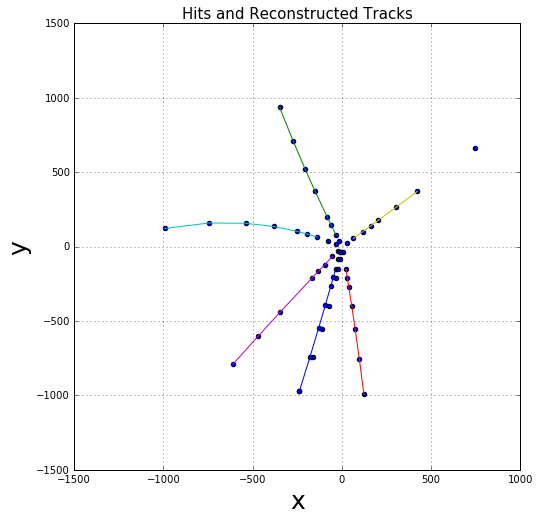

In [7]:
plt.figure(figsize=(8,8))
plt.scatter(event.x.values, event.y.values)

for track in track_inds:
    
    xs = event.x.values[track]
    ys = event.y.values[track]
    
    sort_inds = xs.argsort()
    
    plt.plot(xs[sort_inds], ys[sort_inds])

plt.title("Hits and Reconstructed Tracks", size=15)
plt.xlabel("x", size=25)
plt.ylabel("y", size=25)
plt.grid(b=1)
plt.show()

In [8]:
track_params

array([[  2.91554849e+00,   3.23393798e-05],
       [  4.03442864e-01,   9.49837865e-05],
       [  3.28913178e+00,   5.01199528e-05],
       [  4.22717619e+00,   7.12402047e-04],
       [ -6.75146625e-01,   3.50511306e-05],
       [  2.27816506e+00,   5.16027327e-05]])

## Several events

**TrackRecognizer** is used to recognize tracks in several events using a track pattern recognition method. The method should has the following structure:

In [9]:
class Method(object):
    
    def __init__(self, params):
        
        # You code
        
        pass
    
    def predict(self, x, y):
        
        # Your code
        
        self.track_inds_

In [10]:
from recognizer import TrackRecognizer

method = ModifiedHough(n_theta_bins=5000, n_radius_bins=1000, min_radius=20., min_hits=6)

tr = TrackRecognizer(method=method)
results = tr.predict(data)

results.head()

,event,track,hit_index,x,y
0,0,0,3,-35.433651,-150.895515
1,0,0,23,-237.993471,-971.266754
2,0,0,29,-178.767664,-740.733503
3,0,0,30,-242.167696,-970.234408
4,0,0,32,-93.036300,-394.169059


## Quality metrics

In [11]:
from metrics import RecognitionQuality

rq = RecognitionQuality(data, results, track_eff_threshold=0.8, min_hits_per_track=6)
report_event, report_tracks = rq.calculate()

In [12]:
report_event.head()

,Event,ReconstructionEfficiency,GhostRate,CloneRate,AvgTrackEfficiency
0,0,0.857143,0.000000,0,0.979167
1,1,0.666667,0.166667,0,0.925000
2,2,0.800000,0.000000,0,1.000000
3,3,0.555556,0.111111,0,0.958333
4,4,0.875000,0.125000,0,0.972222


In [13]:
report_event.mean(axis=0)

Event                       49.500000
ReconstructionEfficiency     0.847816
GhostRate                    0.040700
CloneRate                    0.000000
AvgTrackEfficiency           0.972842
dtype: float64

In [14]:
report_tracks.head()

,Event,Track,TrackEfficiency
0,0,0,0.875
1,0,1,1.000
2,0,2,1.000
3,0,3,1.000
4,0,4,1.000
